In [1]:
# Install required packages (if not already installed)
!pip3 install tqdm numpy matplotlib opencv-python pillow torch torchvision torchaudio tensorboard scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
# Imports
import os
import random
import datetime
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

/Users/leoyaoair23/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Fix seed for reproducibility
random.seed(42)
torch.manual_seed(42)

In [4]:
# Configuration
default_image_size = 200
batch_size = 64
num_epochs = 50
learning_rate = 1e-4
patience = 5  # early stopping patience

train_dir = 'dataset_small/Training'
test_dir  = 'dataset_small/Testing'
labels = ['glioma','meningioma','notumor','pituitary']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((default_image_size, default_image_size)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05,0.05)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])
val_transforms = transforms.Compose([
    transforms.Resize((default_image_size, default_image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

In [6]:
# Helper: image file check
def is_image_file(fname):
    return any(fname.lower().endswith(ext) for ext in ['.png','.jpg','.jpeg','.bmp'])

# Dataset for classification
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.samples = []
        self.label_map = {lbl:i for i,lbl in enumerate(labels)}
        self.transform = transform
        for lbl in labels:
            p = os.path.join(root_dir, lbl)
            for fname in os.listdir(p):
                if is_image_file(fname):
                    self.samples.append((os.path.join(p,fname), self.label_map[lbl]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, lbl

In [7]:
# Prepare data loaders
full_train_ds = BrainTumorDataset(train_dir, labels, transform=train_transforms)
train_size = int(0.75 * len(full_train_ds))
val_size   = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_ds.dataset.transform = val_transforms

test_ds = BrainTumorDataset(test_dir, labels, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

In [8]:
# U-Net modules
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self,x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch,out_ch)
        )
    def forward(self,x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        # up conv reduces in_ch -> out_ch
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        # conv expects skip_ch + out_ch -> out_ch
        self.conv = DoubleConv(skip_ch + out_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# U-Net classification model
class UNetClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(512, 512, 256)
        self.up2 = Up(256, 256, 128)
        self.up3 = Up(128, 128, 64)
        self.up4 = Up(64, 64, 64)
        # After final up, apply classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        c1 = self.inc(x)
        c2 = self.down1(c1)
        c3 = self.down2(c2)
        c4 = self.down3(c3)
        c5 = self.down4(c4)
        u1 = self.up1(c5,c4)
        u2 = self.up2(u1,c3)
        u3 = self.up3(u2,c2)
        u4 = self.up4(u3,c1)
        pooled = self.avgpool(u4).view(x.size(0), -1)
        logits = self.fc(pooled)
        return logits

In [9]:
# Instantiate model, loss, optimizer, scheduler
model = UNetClassifier(n_classes=len(labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=patience)

# TensorBoard setup
logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
writer = SummaryWriter(logdir)

In [10]:
# Utility: confusion matrix plot
def plot_confusion_matrix(cm, class_names):
    fig = plt.figure(figsize=(8,8))
    plt.matshow(cm, cmap='Blues', fignum=fig.number)
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    plt.ylabel('True')
    plt.xlabel('Pred')
    return fig

In [11]:
# Training loop with early stopping
best_val_loss = float('inf')
no_improve = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss=0.0; running_corrects=0; total=0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - train"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward(); optimizer.step()
        running_loss += loss.item()*inputs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += torch.sum(preds==targets.data)
        total += inputs.size(0)
    epoch_train_loss = running_loss/total
    epoch_train_acc  = running_corrects.double()/total

    # Validation
    model.eval()
    val_loss=0.0; val_corrects=0; val_total=0; all_preds=[]; all_targs=[]
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()*inputs.size(0)
            preds = outputs.argmax(dim=1)
            val_corrects += torch.sum(preds==targets.data)
            val_total += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targs.extend(targets.cpu().numpy())
    epoch_val_loss = val_loss/val_total
    epoch_val_acc  = val_corrects.double()/val_total

    # Scheduler step
    scheduler.step(epoch_val_loss)

    # Logging
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc.item())
    val_accs.append(epoch_val_acc.item())

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)
    writer.add_scalar('Acc/train', epoch_train_acc, epoch)
    writer.add_scalar('Acc/val', epoch_val_acc, epoch)
    cm = confusion_matrix(all_targs, all_preds)
    fig = plot_confusion_matrix(cm, labels)
    writer.add_figure('Confusion Matrix', fig, epoch)

    # Early stopping & checkpoint
    if epoch_val_loss < best_val_loss - 1e-3:
        best_val_loss = epoch_val_loss
        no_improve = 0
        torch.save(model.state_dict(),'best_unet_classifier.pth')
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

Epoch 1/50 - train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50 - train: 100%|██████████| 1/1 [00:49<00:00, 49.76s/it]


Epoch 1/50 | Train Loss: 1.3476 Acc: 0.3333 | Val Loss: 1.3872 Acc: 0.4000


Epoch 2/50 - train: 100%|██████████| 1/1 [01:08<00:00, 68.11s/it]


Epoch 2/50 | Train Loss: 1.2990 Acc: 0.4000 | Val Loss: 1.3889 Acc: 0.1000


Epoch 3/50 - train: 100%|██████████| 1/1 [00:48<00:00, 48.60s/it]


Epoch 3/50 | Train Loss: 1.2613 Acc: 0.4000 | Val Loss: 1.3903 Acc: 0.1000


Epoch 4/50 - train: 100%|██████████| 1/1 [00:55<00:00, 55.75s/it]


Epoch 4/50 | Train Loss: 1.2319 Acc: 0.4333 | Val Loss: 1.3914 Acc: 0.1000


Epoch 5/50 - train: 100%|██████████| 1/1 [00:42<00:00, 42.65s/it]


Epoch 5/50 | Train Loss: 1.2082 Acc: 0.4667 | Val Loss: 1.3927 Acc: 0.1000


Epoch 6/50 - train: 100%|██████████| 1/1 [00:39<00:00, 39.07s/it]


Early stopping at epoch 6


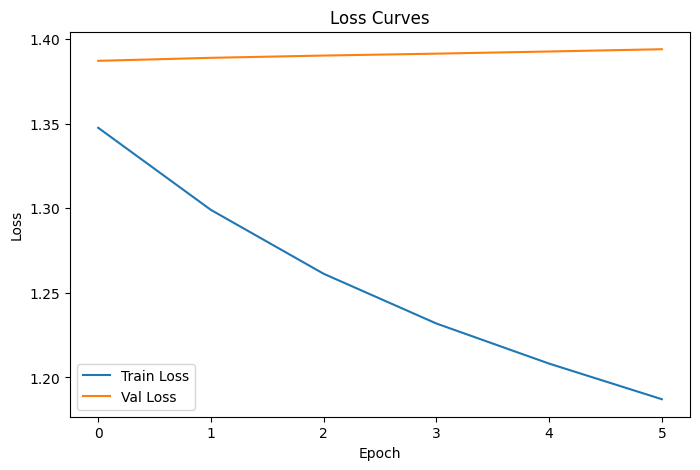

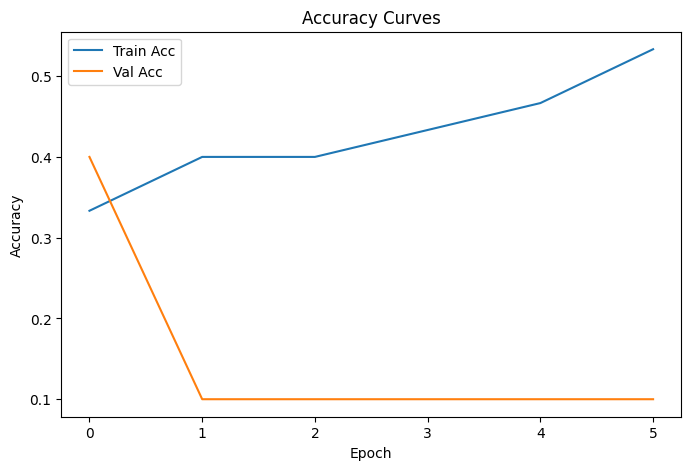

In [12]:
# Plot learning curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [13]:
# Evaluation on test set
model.load_state_dict(torch.load('best_unet_classifier.pth'))
model.eval()
test_loss=0.0; test_corrects=0; test_total=0; preds_list=[]; targs_list=[]
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()*inputs.size(0)
        preds = outputs.argmax(dim=1)
        test_corrects += torch.sum(preds==targets.data)
        test_total += inputs.size(0)
        preds_list.extend(preds.cpu().numpy())
        targs_list.extend(targets.cpu().numpy())

test_loss /= test_total
test_acc  = test_corrects.double()/test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 1.3869, Test Acc: 0.3750


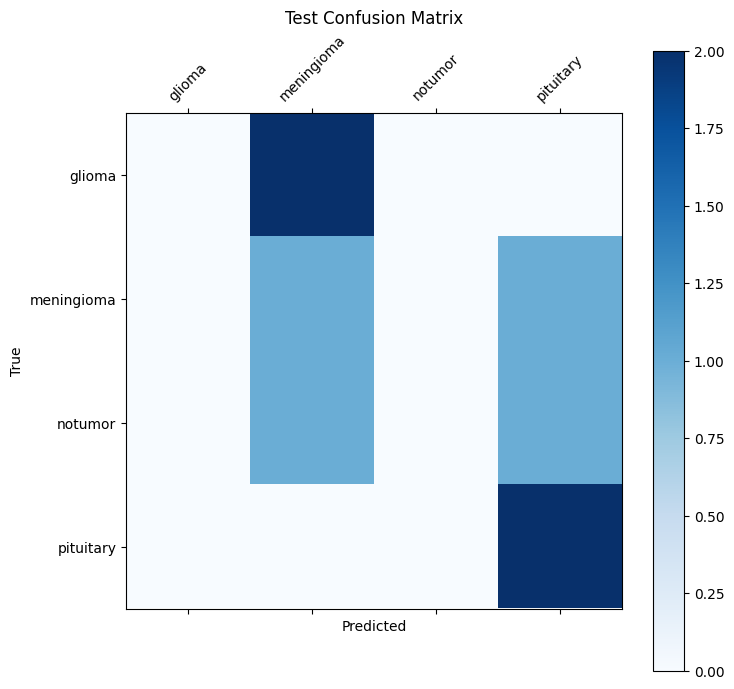

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00         2
  meningioma       0.25      0.50      0.33         2
     notumor       0.00      0.00      0.00         2
   pituitary       0.50      1.00      0.67         2

    accuracy                           0.38         8
   macro avg       0.19      0.38      0.25         8
weighted avg       0.19      0.38      0.25         8



/Users/leoyaoair23/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leoyaoair23/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/leoyaoair23/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [14]:
cm = confusion_matrix(targs_list, preds_list)
plt.figure(figsize=(8,8))
plt.matshow(cm, cmap='Blues', fignum=plt.gcf().number)
plt.title('Test Confusion Matrix')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(targs_list, preds_list, target_names=labels))

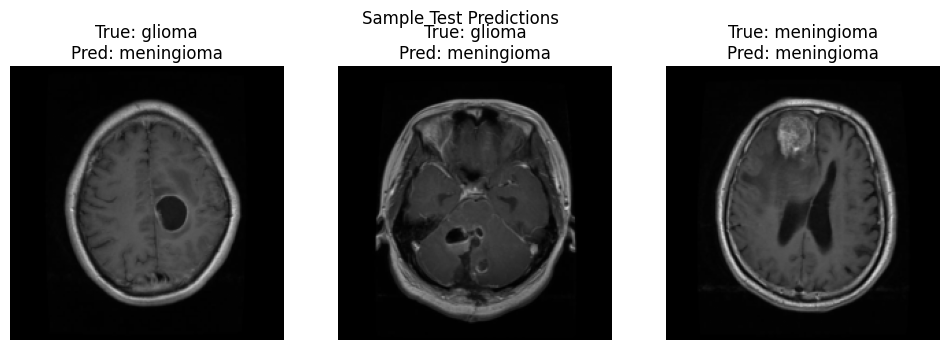

In [15]:
# Display some sample predictions
fig, axes = plt.subplots(1,3,figsize=(12,4))
for i,ax in enumerate(axes.flatten()):
    img, label = test_ds[i]
    inp = img.unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(inp)
    pred = out.argmax(dim=1).item()
    im = img * 0.5 + 0.5  # unnormalize
    im = im.permute(1,2,0).cpu().numpy()
    ax.imshow(im)
    ax.set_title(f"True: {labels[label]}\nPred: {labels[pred]}")
    ax.axis('off')
plt.suptitle('Sample Test Predictions')
plt.show()